In [ ]:
import json
import zipfile
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

import spacy


In [ ]:
# Define the path to the ZIP file containing the dataset
zip_path = "/content/tad_coursework_archives.zip"

# Open the ZIP file in read mode ('r') and extract its contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/extracted")  # Extract files to the specified folder

# List the extracted files to verify successful extraction and identify the JSON file
extracted_files = os.listdir("/content/extracted")
print("Extracted Files:", extracted_files)  # Print the names of extracted files

# Define the path to the JSON file inside the extracted folder
json_path = "/content/extracted/dataset.json"

# Open and read the JSON file
with open(json_path, "r") as json_file:
    json_data = json.load(json_file)  # Load JSON data into a Python dictionary

# Print the loaded JSON data for inspection or further processing
print(json_data)

Extracted Files: ['dataset.json', 'llm_prompt_template_3.json', 'llm_prompt_template_1.json', 'llm_prompt_template_2.json']
{'train': [{'id': '08838524-6d11-729c-39d8-fa4d712b7476', 'labl': 1, 'description': 'Exhaust steam pipe protector piece fitted below ashpan door Copy drawing EO V2.40 Darlington; B2 Darlington 1943 2 cylinders (B17 rebuild deleted); Darlington; Gorton B1 1948 Classes A2, A3, A4, C2, D1, D2, D3, K2, K3, K4, P2, V2, V4 B1, B2'}, {'id': '467eb98e-1866-708e-03cd-9ab9f8a7f4e5', 'labl': 'oyal Botanic Gardens, Kew', 'content': "This journal seems to have been kept parallel with RM 1/17 (FKW/1/17), covering Kingdon-Ward's time teaching at the RAF Jungle School up to the end of 1944. In early 1945, not having been offered any work, Kingdon Ward took a trip on the Brahmaputra. In June, he is offered a job on a tea plantation until 30 Nov when he is told to report to Calcutta."}, {'id': '7ab43067-856c-5cee-8574-ac59a24de44b', 'labl': 'Royal Botanic Gardens, Kew', 'text': Non

## Q1 - Training Data Cleaning [9 marks]
Download and load the dataset. There are some issues with the training split of the data that would stop it being used to train a classifier. Report all issues and how you fixed them.


QUESTION: There is no split regarding the data.

In [ ]:
# Extract the training, validation, and test datasets from the loaded JSON data
train_dset = json_data["train"]
val_dset   = json_data["val"]
test_dset  = json_data["test"]

# Print the number of samples in each dataset
print(f"Number of training samples: {len(train_dset)}")
print(f"Number of validation samples: {len(val_dset)}")
print(f"Number of test samples: {len(test_dset)}")

Number of training samples: 155
Number of validation samples: 50
Number of test samples: 50


In [ ]:
# Function to extract unique keys from a dataset (assuming each item is a dictionary)
def extract_unique_keys(data):
  return {field for entry in data for field in entry.keys()}

In [ ]:
# Extract unique keys from training, validation, and test datasets
train_keys = extract_unique_keys(train_dset)  # Extract keys from the training dataset
val_keys   = extract_unique_keys(val_dset)    # Extract keys from the validation dataset
test_keys  = extract_unique_keys(test_dset)   # Extract keys from the test dataset

# Print the unique keys found in each dataset
print(f"Unique keys in training dataset: {train_keys}")
print(f"Unique keys in validation dataset: {val_keys}")
print(f"Unique keys in test dataset: {test_keys}")

Unique keys in training dataset: {'id', 'label', 'content', 'text', 'description', 'key', 'labl'}
Unique keys in validation dataset: {'id', 'label', 'content'}
Unique keys in test dataset: {'id', 'label', 'content'}


In [ ]:
train_dset[0].keys()

dict_keys(['id', 'labl', 'description'])

In [ ]:
# A dictionary to standardize the key names across different datasets
key_map = {
    'description': 'content',  # Convert 'description' to 'content'
    'text': 'content',         # Convert 'text' to 'content'
    'labl': 'label',           # Fix the typo 'labl' to 'label'
    'key': 'label',            # Standardize 'key' as 'label'
}

def adjust_key(key, mapping_dict):
    """
    A helper function to map a key to a standardized key name.

    Parameters:
        key (str): The key to be standardized.
        mapping_dict (dict): The dictionary containing mappings from incorrect to standardized keys.

    Returns:
        str: The standardized key.
    """
    return mapping_dict.get(key, key)  # Return the standardized key if found, otherwise return the original key

def process_data_points(data, mapping_dict):
    """
    Processes a dataset to standardize its key names.

    Parameters:
        data (list of dicts): The dataset where each entry is a dictionary.
        mapping_dict (dict): A dictionary containing the key mappings.

    Returns:
        list of dicts: The dataset with standardized keys.
    """
    standardized_data = []  # This will store the processed entries with corrected keys

    # Iterate through each data point (dictionary) in the dataset
    for entry in data:
        standardized_entry = {}  # Start with an empty dictionary for the processed data point

        # Ensure required fields ('id', 'label', 'content') are included, even if missing in the original entry
        standardized_entry['id'] = None
        standardized_entry['label'] = None
        standardized_entry['content'] = None

        # Iterate through the original dictionary and map keys to standardized names
        for key, value in entry.items():
            # Use the helper function to standardize the key
            standardized_key = adjust_key(key, mapping_dict)
            standardized_entry[standardized_key] = value  # Assign the original value to the standardized key

        standardized_data.append(standardized_entry)  # Append the processed entry to the new dataset

    return standardized_data

# Applying the process function to the dataset (train_dset as an example)
train_data_standardized = process_data_points(train_dset, key_map)

# Display the first processed entry to verify the key standardization
print(train_data_standardized[0])

{'id': '08838524-6d11-729c-39d8-fa4d712b7476', 'label': 1, 'content': 'Exhaust steam pipe protector piece fitted below ashpan door Copy drawing EO V2.40 Darlington; B2 Darlington 1943 2 cylinders (B17 rebuild deleted); Darlington; Gorton B1 1948 Classes A2, A3, A4, C2, D1, D2, D3, K2, K3, K4, P2, V2, V4 B1, B2'}


In [ ]:
# After manually inspecting the data, I noticed inconsistencies in the labels.
# To effectively analyze and clean these irregularities, I will convert the data
# into a Pandas DataFrame. This allows to leverage Pandas' powerful tools
# for handling missing values, filtering, and transformations.

# Convert the processed datasets into Pandas DataFrames for easier manipulation
train_df = pd.DataFrame(train_data_standardized)  # Training dataset as a DataFrame
val_df   = pd.DataFrame(val_dset)    # Validation dataset as a DataFrame
test_df  = pd.DataFrame(test_dset)   # Test dataset as a DataFrame

In [ ]:
# Based on the task description, we are supposed to have five distinct labels,
# but upon inspection, I find that there are 15 different labels. This discrepancy
# will require us to clean and fix the labels. Additionally, some rows have missing labels.

def check_labels(df):
    """
    Function to check the number of unique labels in the dataset.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the dataset, which includes a 'label' column.

    Returns:
        int: The number of unique labels present in the 'label' column of the DataFrame.
    """
    # Extract all unique labels from the 'label' column
    labels = df['label'].unique()

    # Return the count of unique labels
    return len(labels)

In [ ]:
# Check the number of unique labels in the training, validation, and test datasets
train_labl_num = check_labels(train_df)  # Get the number of unique labels in the training dataset
val_labl_num   = check_labels(val_df)    # Get the number of unique labels in the validation dataset
test_labl_num  = check_labels(test_df)   # Get the number of unique labels in the test dataset

# Print the number of unique labels for each dataset
print(f"Number of unique labels in the training dataset: {train_labl_num}")
print(f"Number of unique labels in the validation dataset: {val_labl_num}")
print(f"Number of unique labels in the test dataset: {test_labl_num}")

Number of unique labels in the training dataset: 15
Number of unique labels in the validation dataset: 5
Number of unique labels in the test dataset: 5


In [ ]:
# There is an issue with the training labels. To fix this,
# I will create a function that converts the labels into numerical values
# based on a predefined mapping using fuzzy matching to match labels to the list.

# Install fuzzywuzzy for fuzzy string matching
!pip install fuzzywuzzy
from fuzzywuzzy import process  # Import fuzzywuzzy for label matching

# List of correct institution labels (used for fuzzy matching)
labels_list = [
    "National Maritime Museum",
    "National Railway Museum",
    "Royal Botanic Gardens, Kew",
    "Royal College of Physicians of London",
    "Shakespeare Birthplace Trust"
]

# Function to fix labels using fuzzy string matching
def fix_labels(df):
    """
    Function to correct labels in the dataset using fuzzy matching.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the dataset with 'label' column.

    Returns:
        pandas.DataFrame: DataFrame with corrected labels.
    """
    corrected_labels = []  # List to store corrected labels

    for label in df['label']:
        if isinstance(label, int):
            # If the label is already a valid integer (0-4), it is assumed to be correct
            corrected_labels.append(label)
        else:
            # Use fuzzywuzzy to find the best match from the predefined labels_list
            best_match, score = process.extractOne(str(label), labels_list)

            # Ensure the best match is valid and in the predefined list before assigning it
            if best_match in labels_list and score > 80:
              corrected_labels.append(labels_list.index(best_match))  # Convert name to index
            else:
              corrected_labels.append(None)  # Assign None if no valid match is found

    df['label'] = corrected_labels  # Update the DataFrame with the corrected labels
    return df

# Apply the label correction function to the training, validation, and test datasets
train_df = fix_labels(train_df)  # Fix labels in the training set
val_df = fix_labels(val_df)      # Fix labels in the validation set
test_df = fix_labels(test_df)    # Fix labels in the test set

# Check and print the unique labels in each dataset after correction
print(f"Unique labels in the training dataset: {train_df['label'].unique()}")
print(f"Unique labels in the validation dataset: {val_df['label'].unique()}")
print(f"Unique labels in the test dataset: {test_df['label'].unique()}")

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Unique labels in the training dataset: [1 2 4 0 3]
Unique labels in the validation dataset: [1 3 4 2 0]
Unique labels in the test dataset: [4 2 1 0 3]


In [ ]:
# Function to check and remove missing values
def clean_null_values(df, name):
    """
    Identifies and removes missing values from a given dataset.

    Parameters:
        df (pd.DataFrame): The dataset to clean.
        name (str): Name of the dataset (for display purposes).

    Returns:
        None (Modifies the DataFrame in place).
    """

    # Count the number of missing values in each column
    null_counts = df.isnull().sum()
    print(f"Missing values in {name} dataset before cleanup:\n{null_counts}\n")

    # Remove rows where 'content' is missing, since it is essential for analysis
    df.dropna(subset=['content'], inplace=True)

    # Check and print missing values after cleanup
    print(f"Missing values in {name} dataset after cleanup:\n{df.isnull().sum()}\n")
    print("-" * 70)  # Separator for better readability

# Apply function to train, validation, and test datasets
clean_null_values(train_df, "Training")
clean_null_values(val_df, "Validation")
clean_null_values(test_df, "Test")

Missing values in Training dataset before cleanup:
id         0
label      0
content    2
dtype: int64

Missing values in Training dataset after cleanup:
id         0
label      0
content    0
dtype: int64

----------------------------------------------------------------------
Missing values in Validation dataset before cleanup:
id         0
label      0
content    0
dtype: int64

Missing values in Validation dataset after cleanup:
id         0
label      0
content    0
dtype: int64

----------------------------------------------------------------------
Missing values in Test dataset before cleanup:
id         0
label      0
content    0
dtype: int64

Missing values in Test dataset after cleanup:
id         0
label      0
content    0
dtype: int64

----------------------------------------------------------------------


In [ ]:
# Check the datatype of the text column
print(f"{train_df['content'].dtype = }")
print(f"{val_df['content'].dtype   = }")
print(f"{test_df['content'].dtype  = }")

# Identify and drop non-string values in the 'content' column of the train_df
train_df = train_df[train_df['content'].apply(lambda x: isinstance(x, str))]

# Reset index
train_df.reset_index(drop=True, inplace=True)

# Ensure that all datasets are of string type for consistency
train_df['content'] = train_df['content'].astype(str)
val_df['content'] = val_df['content'].astype(str)
test_df['content'] = test_df['content'].astype(str)

train_df['content'].dtype = dtype('O')
val_df['content'].dtype   = dtype('O')
test_df['content'].dtype  = dtype('O')


<ipython-input-13-263bb3fe935b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['content'] = train_df['content'].astype(str)


In [ ]:
# Function to check and enforce string type for the 'content' column
def enforce_text_type(df, name):
    """Ensures that all entries in the 'content' column are strings."""
    print(f"Before conversion, '{name}' dataset content type: {df['content'].dtype}")

    # Convert content to string type if necessary
    df['content'] = df['content'].astype(str)

    # Verify conversion
    print(f"After conversion, '{name}' dataset content type: {df['content'].dtype}")
    print("-" * 70)

# Apply function to all datasets
enforce_text_type(train_df, "Training")
enforce_text_type(val_df, "Validation")
enforce_text_type(test_df, "Test")

# Convert 'content' column to string type for all datasets
datasets = {'Training': train_df, 'Validation': val_df, 'Test': test_df}

for name, df in datasets.items():
    df['content'] = df['content'].astype(str)
    print(f"Converted 'content' column to string in {name} dataset.")

# Confirm every row in 'content' is a string
for name, df in datasets.items():
    if df['content'].apply(lambda x: isinstance(x, str)).all():
        print(f" All values in '{name}' dataset 'content' column are strings.")
    else:
        print(f" Warning: Non-string values found in '{name}' dataset.")

Before conversion, 'Training' dataset content type: object
After conversion, 'Training' dataset content type: object
----------------------------------------------------------------------
Before conversion, 'Validation' dataset content type: object
After conversion, 'Validation' dataset content type: object
----------------------------------------------------------------------
Before conversion, 'Test' dataset content type: object
After conversion, 'Test' dataset content type: object
----------------------------------------------------------------------
Converted 'content' column to string in Training dataset.
Converted 'content' column to string in Validation dataset.
Converted 'content' column to string in Test dataset.
 All values in 'Training' dataset 'content' column are strings.
 All values in 'Validation' dataset 'content' column are strings.
 All values in 'Test' dataset 'content' column are strings.


<ipython-input-14-7eab88bde4a8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['content'].astype(str)
<ipython-input-14-7eab88bde4a8>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['content'].astype(str)


## Q2: Exploration [5 marks]
Once the training set has been fixed, report the following:
- The sample counts for the training, validation and test sets
- The percentage splits for training, validation and test sets
- The minimum and maximum length (in characters) of the texts. Report separately for the training, validation and test sets
- The most frequent five tokens in each class (after tokenizing with text_pipeline_spacy from Lab 2)

In [ ]:
# Store dataset lengths in a dictionary
split_lengths = {
    'train': len(train_df),  # Get the number of samples in the training dataset
    'val': len(val_dset),    # Get the number of samples in the validation dataset
    'test': len(test_dset)   # Get the number of samples in the test dataset
}

# Calculate the total number of samples across all datasets
total_count = sum(split_lengths.values())

# Create a summary DataFrame containing dataset statistics
split_stats = pd.DataFrame([
    {
        'Split': split.upper(),  # Convert dataset name to uppercase (TRAIN, VAL, TEST)
        'Samples': count,        # Store the sample count for the dataset
        'Percentage': round((count / total_count) * 100, 2)  # Calculate and round the percentage share
    }
    for split, count in split_lengths.items()  # Iterate through the dataset sizes
])

# Display the dataset statistics
print("Sample counts and percentage splits for the datasets:\n")
print(split_stats.to_string(index=False))  # Print the DataFrame without the index

# Display the total number of samples
print(f"\nTotal number of samples: {total_count}")

Sample counts and percentage splits for the datasets:

Split  Samples  Percentage
TRAIN      150        60.0
  VAL       50        20.0
 TEST       50        20.0

Total number of samples: 250


In [ ]:
max(train_df['content'].str.len())
min(train_df['content'].str.len())

163

In [ ]:
# Function to compute min and max text lengths in a dataset
def calculate_text_lengths(df, name):
    lengths = df['content'].str.len()
    max_length, min_length = lengths.max(), lengths.min()
    print(f"{name} Dataset:")
    print(f"\t Longest text: {max_length} characters")
    print(f"\t Shortest text: {min_length} characters")
    print("-" * 50)
    return max_length, min_length

# Loop over datasets to compute min/max lengths
length_stats = {name: calculate_text_lengths(df, name) for name, df in datasets.items()}

Training Dataset:
	 Longest text: 4263 characters
	 Shortest text: 163 characters
--------------------------------------------------
Validation Dataset:
	 Longest text: 2794 characters
	 Shortest text: 154 characters
--------------------------------------------------
Test Dataset:
	 Longest text: 3479 characters
	 Shortest text: 167 characters
--------------------------------------------------


In [ ]:
# text_pipeline_spacy from Lab 2

nlp = spacy.load("en_core_web_sm")

def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space:
            tokens.append(t.lemma_.lower())
    return tokens

# Example usage:
text_pipeline_spacy("Of all the things I miss, I miss my mind the most.")

['thing', 'miss', 'miss', 'mind']

In [ ]:
from collections import Counter  # For counting token occurrences
from rich.console import Console  # For displaying formatted output
from rich.table import Table  # For creating structured tables

console = Console()  # Initialize console for rich output

def compute_top_tokens(df, n=5):
    """
    Computes the top N most frequent tokens for each class in a dataset.

    Parameters:
        df (pd.DataFrame): The dataset containing 'label' and 'content' columns.
        n (int): The number of top tokens to retrieve per class.

    Returns:
        dict: A dictionary where keys are class labels and values are lists of top N tokens with their counts.
    """
    token_counts = {i: Counter() for i in range(5)}  # Initialize token counters for each class (assuming 5 classes)

    # Tokenize text and count token occurrences for each class
    for label, text in zip(df['label'], df['content']):
        token_counts[label].update(text_pipeline_spacy(text))  # Tokenize and count occurrences

    # Retrieve the top N tokens for each class
    return {cls: counter.most_common(n) for cls, counter in token_counts.items()}

# Compute the most frequent tokens for each dataset
top_tokens = {
    "Training": compute_top_tokens(train_df),
    "Validation": compute_top_tokens(val_df),
    "Test": compute_top_tokens(test_df)
}

# Display results in a structured table format using Rich
for dataset, class_tokens in top_tokens.items():
    console.print(f"\n[bold underline cyan]{dataset} Dataset[/bold underline cyan]")

    for class_id, tokens in class_tokens.items():
        label = labels_list[class_id]  # Retrieve the corresponding label name

        # Create a Rich table for displaying token statistics
        table = Table(title=f"Top 5 Tokens for [green]{label}[/green]", show_header=True, header_style="bold magenta")
        table.add_column("Token", style="yellow")  # Token column
        table.add_column("Count", justify="right", style="white")  # Count column

        # Populate the table with top tokens and their frequencies
        for token, count in tokens:
            table.add_row(token, str(count))

        console.print(table)  # Display the table

Training Dataset

  Top 5 Tokens for   
  National Maritime  
       Museum        
┏━━━━━━━━━━━┳━━━━━━━┓
┃ Token     ┃ Count ┃
┡━━━━━━━━━━━╇━━━━━━━┩
│ john      │    16 │
│ sir       │    11 │
│ henry     │    10 │
│ enclosure │    10 │
│ james     │     9 │
└───────────┴───────┘

   Top 5 Tokens for   
   National Railway   
        Museum        
┏━━━━━━━━━━━━┳━━━━━━━┓
┃ Token      ┃ Count ┃
┡━━━━━━━━━━━━╇━━━━━━━┩
│ 2000       │   144 │
│ 7200       │   144 │
│ 756        │   143 │
│ gb         │   142 │
│ collection │    31 │
└────────────┴───────┘

 Top 5 Tokens for  
   Royal Botanic   
   Gardens, Kew    
┏━━━━━━━━━┳━━━━━━━┓
┃ Token   ┃ Count ┃
┡━━━━━━━━━╇━━━━━━━┩
│ letter  │    30 │
│ include │    15 │
│ paper   │    14 │
│ list    │    12 │
│ contain │    11 │
└─────────┴───────┘

 Top 5 Tokens for  
 Royal College of  
   Physicians of   
      London       
┏━━━━━━━━━┳━━━━━━━┓
┃ Token   ┃ Count ┃
┡━━━━━━━━━╇━━━━━━━┩
│ seal    │    25 │
│ common  │    21 │
│ mr.     │    17 │
│ college │    17 │
│ fellow  │    16 │
└─────────┴───────┘

 Top 5 Tokens for  
    Shakespeare    
 Birthplace Trust  
┏━━━━━━━━━┳━━━━━━━┓
┃ Token   ┃ Count ┃
┡━━━━━━━━━╇━━━━━━━┩
│ mr.     │    18 │
│ work    │    16 │
│ bill    │    15 │
│ account │    14 │
│ letter  │    14 │
└─────────┴───────┘

Validation Dataset

 Top 5 Tokens for  
 National Maritime 
      Museum       
┏━━━━━━━━━┳━━━━━━━┓
┃ Token   ┃ Count ┃
┡━━━━━━━━━╇━━━━━━━┩
│ mr.     │     6 │
│ hyt     │     3 │
│ letter  │     3 │
│ account │     3 │
│ knowe   │     2 │
└─────────┴───────┘

 Top 5 Tokens for  
 National Railway  
      Museum       
┏━━━━━━━━━┳━━━━━━━┓
┃ Token   ┃ Count ┃
┡━━━━━━━━━╇━━━━━━━┩
│ william │     8 │
│ p.      │     8 │
│ medical │     8 │
│ charles │     7 │
│ witt    │     6 │
└─────────┴───────┘

 Top 5 Tokens for  
   Royal Botanic   
   Gardens, Kew    
┏━━━━━━━━━┳━━━━━━━┓
┃ Token   ┃ Count ┃
┡━━━━━━━━━╇━━━━━━━┩
│ slide   │     7 │
│ letter  │     6 │
│ plant   │     6 │
│ william │     5 │
│ hooker  │     5 │
└─────────┴───────┘

Top 5 Tokens for Royal
College of Physicians 
      of London       
┏━━━━━━━━━━━━┳━━━━━━━┓
┃ Token      ┃ Count ┃
┡━━━━━━━━━━━━╇━━━━━━━┩
│ collection │    17 │
│ class      │    13 │
│ 4          │    12 │
│ photograph │    11 │
│ 2          │    10 │
└────────────┴───────┘

  Top 5 Tokens for   
     Shakespeare     
  Birthplace Trust   
┏━━━━━━━━━━━┳━━━━━━━┓
┃ Token     ┃ Count ┃
┡━━━━━━━━━━━╇━━━━━━━┩
│ john      │     9 │
│ enclosure │     6 │
│ mary      │     4 │
│ joseph    │     4 │
│ de        │     4 │
└───────────┴───────┘

Test Dataset

 Top 5 Tokens for  
 National Maritime 
      Museum       
┏━━━━━━━━━┳━━━━━━━┓
┃ Token   ┃ Count ┃
┡━━━━━━━━━╇━━━━━━━┩
│ william │    10 │
│ john    │     7 │
│ de      │     7 │
│ copy    │     7 │
│ send    │     5 │
└─────────┴───────┘

Top 5 Tokens for 
National Railway 
     Museum      
┏━━━━━━━┳━━━━━━━┓
┃ Token ┃ Count ┃
┡━━━━━━━╇━━━━━━━┩
│ gb    │    29 │
│ 756   │    29 │
│ 2000  │    29 │
│ 7200  │    29 │
│ class │    15 │
└───────┴───────┘

 Top 5 Tokens for 
  Royal Botanic   
   Gardens, Kew   
┏━━━━━━━━┳━━━━━━━┓
┃ Token  ┃ Count ┃
┡━━━━━━━━╇━━━━━━━┩
│ 1936   │    11 │
│ house  │     9 │
│ letter │     9 │
│ kew    │     8 │
│ palm   │     7 │
└────────┴───────┘

  Top 5 Tokens for   
  Royal College of   
Physicians of London 
┏━━━━━━━━━━━┳━━━━━━━┓
┃ Token     ┃ Count ┃
┡━━━━━━━━━━━╇━━━━━━━┩
│ j.        │     5 │
│ william   │     3 │
│ murray    │     3 │
│ mansfield │     3 │
│ charles   │     3 │
└───────────┴───────┘

 Top 5 Tokens for  
    Shakespeare    
 Birthplace Trust  
┏━━━━━━━━━┳━━━━━━━┓
┃ Token   ┃ Count ┃
┡━━━━━━━━━╇━━━━━━━┩
│ mr.     │    13 │
│ letter  │    11 │
│ say     │     8 │
│ langley │     8 │
│ estate  │     8 │
└─────────┴───────┘

## Q3: Prompting with a large language model

- We are going to read the three prompt templates information into a dataframe so we can join them with the true label based id column data dataframes we laready have.

In [ ]:
# Define file paths for the three LLM-generated classification results
file_paths = {
    "template_A": "/content/extracted/llm_prompt_template_1.json",
    "template_B": "/content/extracted/llm_prompt_template_2.json",
    "template_C": "/content/extracted/llm_prompt_template_3.json"
}

# Function to load JSON data from a given file path
def load_json_data(filepath):
    with open(filepath, "r") as file:
        return json.load(file)

# Load data from all three templates into separate dictionaries
llm_results = {key: load_json_data(path) for key, path in file_paths.items()}

# Print the length of each dataset to confirm alignment with the training set
for key, data in llm_results.items():
    print(f"Length of {key}: {len(data)}")

# Convert the JSON lists into Pandas DataFrames for easier manipulation
df_llm_results = {key: pd.DataFrame(data) for key, data in llm_results.items()}

# Display the first 5 rows of one dataset for verification
df_llm_results["template_B"].head(5)

Length of template_A: 150
Length of template_B: 150
Length of template_C: 150


,id,prompt,next_token
0,08838524-6d11-729c-39d8-fa4d712b7476,Record: Exhaust steam pipe protector piece fit...,1
1,467eb98e-1866-708e-03cd-9ab9f8a7f4e5,Record: This journal seems to have been kept p...,2
2,b78f8473-e487-b3cb-be65-4f854d97228b,Record: 'Remainder Correspondence of the Bibli...,3
3,ea15bfc9-9499-e9e2-b3e4-654714a795a5,Record: The particulars of an inquest upon the...,3
4,03556d52-3c1e-f36e-97bd-1a09c87ef949,Record: London Brighton & South Coast Railway ...,1


In [ ]:
# Extract only relevant columns (ID and predicted labels) from LLM-generated DataFrames
df_A = df_llm_results["template_A"][["id", "next_token"]]
df_B = df_llm_results["template_B"][["id", "next_token"]]
df_C = df_llm_results["template_C"][["id", "next_token"]]

# Extract ground truth labels from training data
ground_truth = train_df[["id", "label"]]

# Perform an inner join on all datasets using "id" as the key
df_merged = (
    df_A.merge(df_B, on="id", suffixes=("_A", "_B"))
        .merge(df_C, on="id")
        .merge(ground_truth, on="id")
)

# Rename third LLM output column for consistency
df_merged = df_merged.rename(columns={'next_token': 'next_token_C'})

# Print lengths of datasets before and after merging to confirm no data loss
print(f"Length of template_A predictions: {len(df_A)}")
print(f"Length of template_B predictions: {len(df_B)}")
print(f"Length of template_C predictions: {len(df_C)}")
print(f"Length of merged dataset: {len(df_merged)}")
print(f"Length of ground truth labels: {len(ground_truth)}")

# Display a sample of merged data for verification
df_merged.head(3)

# Analyze unique predicted labels for each prompt template
print(f"Unique classes predicted by template_A: {df_merged['next_token_A'].unique()}")
print(f"Unique classes predicted by template_B: {df_merged['next_token_B'].unique()}")
print(f"Unique classes predicted by template_C: {df_merged['next_token_C'].unique()}")

# Replace invalid outputs with a new hypothetical class (class 5)
df_merged.replace({'next_token_A': {'Based': 5, 'The': 5}}, inplace=True)
df_merged.replace({'next_token_C': {'I': 5, 'None': 5}}, inplace=True)

df_merged.head(4)

Length of template_A predictions: 150
Length of template_B predictions: 150
Length of template_C predictions: 150
Length of merged dataset: 150
Length of ground truth labels: 150
Unique classes predicted by template_A: ['Based' 'The']
Unique classes predicted by template_B: ['1' '2' '3' '4' '0']
Unique classes predicted by template_C: ['1' '2' '0' 'I' '3' '4' 'None']


<ipython-input-21-827beeff1381>:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged.replace({'next_token_A': {'Based': 5, 'The': 5}}, inplace=True)


,id,next_token_A,next_token_B,next_token_C,label
0,08838524-6d11-729c-39d8-fa4d712b7476,5,1,1,1
1,467eb98e-1866-708e-03cd-9ab9f8a7f4e5,5,2,2,2
2,b78f8473-e487-b3cb-be65-4f854d97228b,5,3,1,2
3,ea15bfc9-9499-e9e2-b3e4-654714a795a5,5,3,0,4


In [ ]:
# Display the unique predicted class labels after converting invalid outputs to class 5
print("These are the labels predicted by each prompt template after converting invalid outputs to a sixth class (label 5):")
print(f"Template A predictions: {df_merged['next_token_A'].unique()}")
print(f"Template B predictions: {df_merged['next_token_B'].unique()}")
print(f"Template C predictions: {df_merged['next_token_C'].unique()}")

# Convert predicted labels to integers for evaluation metrics
df_merged['next_token_A'] = df_merged['next_token_A'].astype(int)
df_merged['next_token_B'] = df_merged['next_token_B'].astype(int)
df_merged['next_token_C'] = df_merged['next_token_C'].astype(int)

These are the labels predicted by each prompt template after converting invalid outputs to a sixth class (label 5):
Template A predictions: [5]
Template B predictions: ['1' '2' '3' '4' '0']
Template C predictions: ['1' '2' '0' 5 '3' '4']


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Display class labels after invalid outputs have been converted to class 5
print("Class labels per template after handling invalid predictions:")
for key in ['next_token_A', 'next_token_B', 'next_token_C']:
    print(f"Unique labels in {key}: {df_merged[key].unique()}")

# Ensure prediction columns are in integer format
df_merged['next_token_B'] = df_merged['next_token_B'].astype(int)
df_merged['next_token_C'] = df_merged['next_token_C'].astype(int)

# Evaluation function for a single template's predictions
def evaluate_predictions(y_pred, y_true):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro')
    }

# Compute metrics for all three templates
results = {
    "template_A": evaluate_predictions(df_merged['next_token_A'], df_merged['label']),
    "template_B": evaluate_predictions(df_merged['next_token_B'], df_merged['label']),
    "template_C": evaluate_predictions(df_merged['next_token_C'], df_merged['label']),
}

# Convert results to DataFrame for better readability
df_scores = pd.DataFrame(results).T
df_scores

Class labels per template after handling invalid predictions:
Unique labels in next_token_A: [5]
Unique labels in next_token_B: [1 2 3 4 0]
Unique labels in next_token_C: [1 2 0 5 3 4]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,accuracy,precision_macro,recall_macro,f1_macro
template_A,0.000000,0.000000,0.000000,0.000000
template_B,0.760000,0.788615,0.754925,0.743436
template_C,0.706667,0.674268,0.582762,0.584574


In [ ]:
from sklearn.metrics import classification_report

# Function to generate macro scores and accuracy from a classification report
def extract_macro_metrics(y_pred, y_true):
    report = classification_report(y_true, y_pred, output_dict=True)
    macro_metrics = report['macro avg']
    macro_metrics['accuracy'] = report['accuracy']
    return macro_metrics

# Evaluate each template
macro_scores = {
    "template_A": extract_macro_metrics(df_merged['next_token_A'], df_merged['label']),
    "template_B": extract_macro_metrics(df_merged['next_token_B'], df_merged['label']),
    "template_C": extract_macro_metrics(df_merged['next_token_C'], df_merged['label']),
}

# Create a DataFrame to display the results
df_macro_report = pd.DataFrame(macro_scores)
df_macro_report

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

,template_A,template_B,template_C
precision,0.0,0.788615,0.674268
recall,0.0,0.754925,0.582762
f1-score,0.0,0.743436,0.584574
support,150.0,150.000000,150.000000
accuracy,0.0,0.760000,0.706667


In [ ]:
import os

# Define save path and datasets to export
save_dir = "/content/extracted/"
datasets_to_save = {
    "train_data.csv": train_df,
    "val_data.csv": val_df,
    "test_data.csv": test_df
}

# Save each DataFrame to CSV
for filename, df in datasets_to_save.items():
    file_path = os.path.join(save_dir, filename)
    df.to_csv(file_path, index=False)
    print(f"Saved {filename} to {file_path}")

Saved train_data.csv to /content/extracted/train_data.csv
Saved val_data.csv to /content/extracted/val_data.csv
Saved test_data.csv to /content/extracted/test_data.csv


## Question 4

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# TRansformer related imports
!pip install datasets
import datasets
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import set_seed, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer


# Sk-learn metrics tools
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is 

In [ ]:
# Count how many samples belong to each class in each dataset split
# Count class occurrences in the training set
train_dist = train_df['label'].value_counts().sort_index()

# Count class occurrences in the validation set
val_dist = val_df['label'].value_counts().sort_index()

# Count class occurrences in the test set
test_dist = test_df['label'].value_counts().sort_index()

# Combine all class distributions into one DataFrame for easy comparison
# Concatenate class counts side by side (axis=1 means columns)
class_distribution = pd.concat([train_dist, val_dist, test_dist], axis=1)

# Rename the columns for clarity
class_distribution.columns = ['Train', 'Validation', 'Test']

# Add a 'Label' column to make it easier to identify which class each row refers to
class_distribution['Label'] = class_distribution.index

# Reset the index to turn the class index into a normal numbered index
class_distribution.reset_index(drop=True, inplace=True)

print("Class distribution across dataset splits:")
print(class_distribution)

Class distribution across dataset splits:
   Train  Validation  Test  Label
0     29           8    13      0
1     33          13     7      1
2     28          11    11      2
3     31          10     6      3
4     29           8    13      4


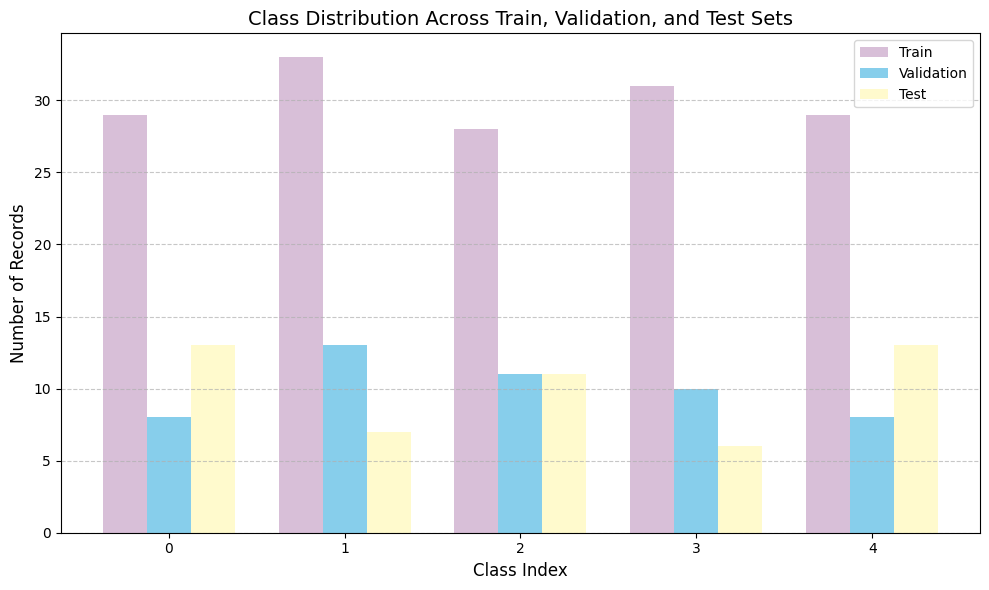

In [ ]:
# --- Prepare data for grouped bar chart ---
labels = class_distribution['Label']
x = np.arange(len(labels))  # the label locations
width = 0.25  # width of each bar

# --- Define custom colors ---
colors = {
    'Train': '#D8BFD8',
    'Validation': 'skyblue',
    'Test': '#FFFACD'
}

# --- Create the plot ---
plt.figure(figsize=(10, 6))

# Plot bars
plt.bar(x - width, class_distribution['Train'], width=width, color=colors['Train'], label='Train')
plt.bar(x, class_distribution['Validation'], width=width, color=colors['Validation'], label='Validation')
plt.bar(x + width, class_distribution['Test'], width=width, color=colors['Test'], label='Test')

# --- Formatting the chart ---
plt.xlabel('Class Index', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.title('Class Distribution Across Train, Validation, and Test Sets', fontsize=14)
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

In [ ]:
# Load CSV files
data_files = {
    "train":      os.path.join(save_dir, "train_data.csv"),
    "validation": os.path.join(save_dir, "val_data.csv"),
    "test":       os.path.join(save_dir, "test_data.csv")
}

dataset = load_dataset("csv", data_files=data_files)

# Print the structure
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'content'],
        num_rows: 150
    })
    validation: Dataset({
        features: ['id', 'label', 'content'],
        num_rows: 50
    })
    test: Dataset({
        features: ['id', 'label', 'content'],
        num_rows: 50
    })
})


In [ ]:
# --- Load the BERT tokenizer ---
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# --- Define a function to tokenize each example ---
def tokenize_record(example_batch):
    return bert_tokenizer(example_batch["content"], padding="max_length", truncation=True)

# --- Apply the tokenizer to the dataset ---
tokenized = dataset.map(tokenize_record, batched=True)

# --- Remove unnecessary original columns ---
tokenized = tokenized.remove_columns(["id", "content"])

# --- Convert labels and inputs to PyTorch tensors ---
tokenized.set_format("torch")

# --- Inspect the tokenized dataset structure ---
print(tokenized)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 150
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50
    })
})


In [ ]:
# --- Define training hyperparameters ---
bert_learning_rate = 5e-5        # Standard learning rate for fine-tuning BERT
bert_batch_size = 8              # Number of samples per batch
bert_num_epochs = 8              # Total number of training epochs
bert_weight_decay = 0.1          # Regularization to prevent overfitting

# --- Load pre-trained BERT model for classification ---
# We're fine-tuning 'bert-base-uncased' on a 5-class classification task
bert_model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=5
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir       = "my_awesome_model", # HuggingFace wants a name for your model
    eval_strategy    = "epoch",            # How often we want to evaluate the model
    learning_rate    = bert_learning_rate,
    logging_strategy = "epoch",
    num_train_epochs = bert_num_epochs,
    # weight_decay     = weight_decay,
    report_to        = 'none',             # Tells it to not use a tracking/reporting system (e.g. Weights & Biases)
    per_device_train_batch_size = bert_batch_size,
    per_device_eval_batch_size  = bert_batch_size,

    )


data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

trainer = Trainer(
    model         = bert_model,                       # The model you want to train
    args          = training_args,                    # The various training arguments set up above
    train_dataset = tokenized['train'],               # The data to use to update the weights
    eval_dataset  = tokenized['validation'],          # The data to use for evaluation
    data_collator = data_collator,                    # A data collator that does clever things moving data around
)


trainer.train()

Epoch,Training Loss,Validation Loss
1,1.454700,1.910086
2,0.935800,2.254995
3,0.454900,2.667185
4,0.145200,3.264820
5,0.046500,3.910605
6,0.020900,4.236006
7,0.014400,4.393044
8,0.012900,4.439538


TrainOutput(global_step=152, training_loss=0.3856669926133595, metrics={'train_runtime': 132.1353, 'train_samples_per_second': 9.082, 'train_steps_per_second': 1.15, 'total_flos': 315741770956800.0, 'train_loss': 0.3856669926133595, 'epoch': 8.0})

In [ ]:
# --- Generate predictions on the validation set ---
validation_results = trainer.predict(tokenized["validation"])

# --- Extract predicted logits and convert to class labels ---
predicted_labels = np.argmax(validation_results.predictions, axis=1)
print(f"Predicted class labels: {predicted_labels}")

# --- Retrieve ground truth labels from the validation dataset ---
true_labels = tokenized["validation"]["label"]
print(f"Actual class labels: {true_labels}")

Predicted class labels: [2 1 3 3 0 1 3 2 0 2 4 2 2 3 2 2 2 3 3 1 1 1 3 3 0 2 2 2 0 4 1 3 3 2 0 2 0
 1 1 2 0 4 2 3 4 4 3 1 0 4]
Actual class labels: tensor([1, 3, 4, 1, 4, 3, 1, 2, 4, 2, 0, 2, 2, 1, 2, 2, 2, 1, 1, 3, 3, 3, 1, 1,
        0, 1, 3, 2, 4, 0, 3, 1, 1, 2, 4, 0, 4, 3, 3, 2, 4, 0, 2, 1, 0, 0, 1, 3,
        4, 0])


In [ ]:
# --- Compute classification metrics (precision, recall, F1-score, accuracy) ---
bert_classification_report = classification_report(true_labels, predicted_labels, digits=4, output_dict=True)

# --- Convert report dictionary into a DataFrame for better visualization ---
bert_metrics_df = pd.DataFrame(bert_classification_report).transpose()

# --- Display the final report ---
bert_metrics_df

,precision,recall,f1-score,support
0,0.125000,0.125,0.125000,8.00
1,0.000000,0.000,0.000000,13.00
2,0.733333,1.000,0.846154,11.00
3,0.000000,0.000,0.000000,10.00
4,0.000000,0.000,0.000000,8.00
accuracy,0.240000,0.240,0.240000,0.24
macro avg,0.171667,0.225,0.194231,50.00
weighted avg,0.181333,0.240,0.206154,50.00


## Q5

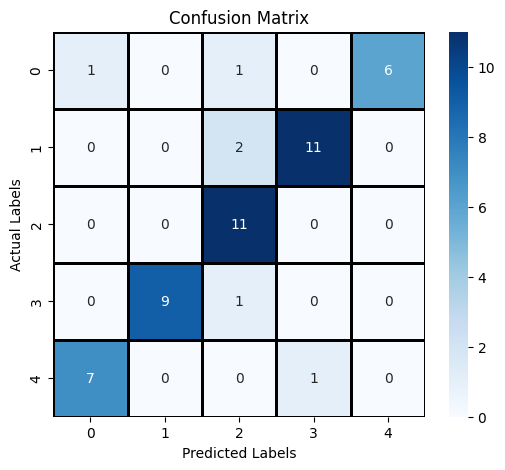

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=1, linecolor="black")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

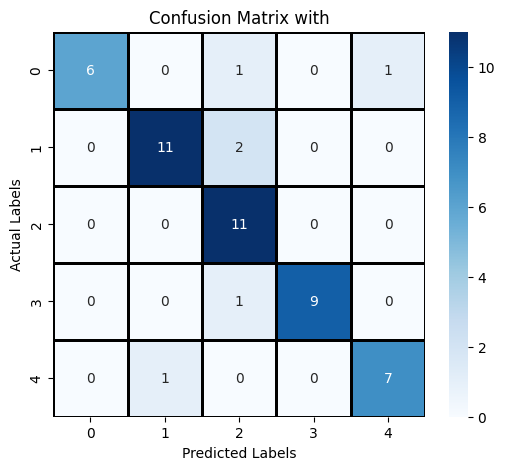

In [ ]:
# Define label mapping
label_mapping = {0: 4, 1: 3, 2: 2, 3: 1, 4: 0}

# Apply mapping to predicted labels
corrected_predictions = [label_mapping[label] for label in predicted_labels]

# Compute the new confusion matrix
new_conf_matrix = confusion_matrix(true_labels, corrected_predictions)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(new_conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=1, linecolor="black")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Create an empty list to store the corrected labels
corrected_labels = []

# Loop through each label in the validation dataset and apply the mapping
for item in val_df['label']:
    corrected_labels.append(label_mapping[item])  # Replace incorrect labels with correct ones

# Add the corrected labels as a new column in the DataFrame
val_df['corrected_labels'] = corrected_labels

# Display the first 5 rows to verify the corrections
val_df.head(5)

,id,label,content,corrected_labels
0,f4737321-5435-fa79-79de-be2467a2ca77,1,"Notebook of William Fleming, Bedell. MS notebo...",3
1,cc1d9c86-5e83-80c2-d566-dc724c663690,3,"Class 2-2-6-0, DETAILS FOR BLOW-DOWN Class 2-2...",1
2,528e5290-f8ff-0eb0-325f-0472b9c1a9ef,4,"Copy letter from I Mayo, 31 Queen Ann Street [...",0
3,bac8d441-4984-861d-5199-b7a97699c728,1,Mr Abernethy's Surgical Essays delivered MDCCC...,3
4,dd0fff6a-c351-dd46-cd26-e2d5c61e479c,4,"M.James, Curate. Certifies that John son of Jo...",0


In [ ]:
# Iterate through each row in the validation dataset with an index
for index, row in val_df.iterrows():
    original_label = row['label']  # Extract the original label
    corrected_label = label_mapping[original_label]  # Get the corrected label using the mapping

    # Check if the label correction is applied properly
    if original_label != corrected_label:
        print(f"Index: {index}, Original label: {original_label}, Corrected label: {corrected_label}")

print("Label checking completed successfully.")

Index: 0, Original label: 1, Corrected label: 3
Index: 1, Original label: 3, Corrected label: 1
Index: 2, Original label: 4, Corrected label: 0
Index: 3, Original label: 1, Corrected label: 3
Index: 4, Original label: 4, Corrected label: 0
Index: 5, Original label: 3, Corrected label: 1
Index: 6, Original label: 1, Corrected label: 3
Index: 8, Original label: 4, Corrected label: 0
Index: 10, Original label: 0, Corrected label: 4
Index: 13, Original label: 1, Corrected label: 3
Index: 17, Original label: 1, Corrected label: 3
Index: 18, Original label: 1, Corrected label: 3
Index: 19, Original label: 3, Corrected label: 1
Index: 20, Original label: 3, Corrected label: 1
Index: 21, Original label: 3, Corrected label: 1
Index: 22, Original label: 1, Corrected label: 3
Index: 23, Original label: 1, Corrected label: 3
Index: 24, Original label: 0, Corrected label: 4
Index: 25, Original label: 1, Corrected label: 3
Index: 26, Original label: 3, Corrected label: 1
Index: 28, Original label: 4

In [ ]:
val_df.drop(columns=['label'], inplace=True)
val_df.rename(columns={'corrected_labels': 'label'}, inplace=True)

val_df.head(10)

,id,content,label
0,f4737321-5435-fa79-79de-be2467a2ca77,"Notebook of William Fleming, Bedell. MS notebo...",3
1,cc1d9c86-5e83-80c2-d566-dc724c663690,"Class 2-2-6-0, DETAILS FOR BLOW-DOWN Class 2-2...",1
2,528e5290-f8ff-0eb0-325f-0472b9c1a9ef,"Copy letter from I Mayo, 31 Queen Ann Street [...",0
3,bac8d441-4984-861d-5199-b7a97699c728,Mr Abernethy's Surgical Essays delivered MDCCC...,3
4,dd0fff6a-c351-dd46-cd26-e2d5c61e479c,"M.James, Curate. Certifies that John son of Jo...",0
5,44a036a8-95f1-f40e-3bf8-cf930f287edc,The British Railways (Western Region) signalli...,1
6,e8f9d3cf-c81b-39da-f0d0-2ba7739a099e,COMMITTEES. Committee of Reference R.C.P. Repo...,3
7,f4100f36-c185-3e99-be1e-b560a1971342,"Letter from Sir William Hooker. The letter, to...",2
8,4f6b8e53-67e1-344f-35b3-463435f1e8ec,List of men who signed for their money from Ca...,0
9,58e0b5f7-d05e-c9ef-cdbe-d0dbcb9a5417,They Called Him Mad. The file contains a types...,2


## Question 6

In [ ]:
# Create a DatasetDict from preprocessed Pandas DataFrames
corrected_dset = DatasetDict({
    "train"     : Dataset.from_pandas(train_df),  # Training dataset
    "validation": Dataset.from_pandas(val_df),    # Validation dataset
    "test"      : Dataset.from_pandas(test_df)    # Test dataset
})

# Print dataset structure to verify correctness
print(corrected_dset)

def preprocess_dataset(model_name, dataset):
    """
    Tokenizes the dataset using the specified model's tokenizer.

    Args:
        model_name (str): The name of the Hugging Face model (e.g., 'bert-base-uncased').
        dataset (DatasetDict): The dataset containing text data.

    Returns:
        DatasetDict: The tokenized dataset formatted for PyTorch.
        tokenizer: The tokenizer used for preprocessing.
    """

    # Load the tokenizer for the specified model
    tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

    # Define a function to tokenize the dataset
    def tokenize_function(examples):
        return tokenizer(examples["content"], padding="max_length", truncation=True)

    # Apply tokenization to the entire dataset
    tokenized_datasets = dataset.map(tokenize_function, batched=True)

    # Remove unnecessary columns ('id' and 'content') to avoid issues during training
    tokenized_datasets = tokenized_datasets.remove_columns(["id", "content"])

    # Convert the dataset format to PyTorch tensors for compatibility with Hugging Face models
    tokenized_datasets = tokenized_datasets.with_format("torch")

    return tokenized_datasets, tokenizer

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'content'],
        num_rows: 150
    })
    validation: Dataset({
        features: ['id', 'content', 'label'],
        num_rows: 50
    })
    test: Dataset({
        features: ['id', 'label', 'content'],
        num_rows: 50
    })
})


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    """
    Computes evaluation metrics (accuracy, precision, recall, and F1-score) for model evaluation.

    Args:
        eval_pred: A tuple containing (logits, labels) from the model predictions.

    Returns:
        dict: A dictionary containing accuracy, precision, recall, and F1-score.
    """

    logits, labels = eval_pred  # Extract model outputs and true labels
    predictions = logits.argmax(axis=-1)  # Convert logits to class predictions

    # Compute precision, recall, and F1-score using macro averaging
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro")

    # Compute overall accuracy
    acc = accuracy_score(labels, predictions)

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

def hyperparameter_tuning(model, tokenizer, dataset, learning_rate=5e-5, batch_size=8, epochs=8, weight_decay=0.1):
    """
    Sets up and configures the Hugging Face Trainer for fine-tuning transformer models.

    Args:
        model: The pre-trained transformer model to be fine-tuned.
        tokenizer: Tokenizer corresponding to the model.
        dataset (DatasetDict): The dataset containing train and validation splits.
        learning_rate (float): Learning rate for the optimizer.
        batch_size (int): Number of samples per batch.
        epochs (int): Number of training epochs.
        weight_decay (float): Weight decay (L2 regularization) for optimizer.

    Returns:
        Trainer: The configured Hugging Face Trainer object.
    """

    # Define training arguments for the Trainer
    training_args = TrainingArguments(
        output_dir="my_awesome_model",  # Directory to save trained model
        evaluation_strategy="epoch",    # Evaluate model at the end of each epoch
        save_strategy="epoch",          # Save model checkpoints at the end of each epoch
        learning_rate=learning_rate,    # Learning rate for optimization
        logging_strategy="epoch",       # Log training progress after each epoch
        num_train_epochs=epochs,        # Number of training epochs
        report_to='none',               # Disable reporting to external tools like WandB
        load_best_model_at_end=True,    # Load the best model based on validation metrics
        metric_for_best_model="f1",     # Select the best model using F1-score
        greater_is_better=True,         # Higher F1-score indicates better model performance

        per_device_train_batch_size=batch_size,  # Training batch size
        per_device_eval_batch_size=batch_size,   # Evaluation batch size
    )

    # Data collator for dynamic padding (ensures efficient batch processing)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Initialize Trainer with model, arguments, dataset, and evaluation metrics
    trainer = Trainer(
        model=model,                          # Transformer model to train
        args=training_args,                   # Training configuration
        train_dataset=dataset['train'],       # Training dataset
        eval_dataset=dataset['validation'],   # Validation dataset
        data_collator=data_collator,          # Handles dynamic padding
        compute_metrics=compute_metrics       # Evaluation function for performance tracking
    )

    return trainer

In [ ]:
# Preprocess the dataset for BERT, using the 'bert-base-uncased' tokenizer and the corrected dataset
tokenized_dataset_bert, tokenizer_bert = preprocess_dataset('bert-base-uncased', corrected_dset)

# Load the pre-trained BERT model for sequence classification with 5 labels
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# Perform hyperparameter tuning on the BERT model using the tokenized dataset and the BERT tokenizer
bert_trainer = hyperparameter_tuning(model, tokenizer_bert, tokenized_dataset_bert)

# Train the BERT model with the hyperparameters tuned earlier
bert_trainer.train()

# Predict the labels for the validation dataset using the trained BERT model
y_pred_all_BERT_2 = bert_trainer.predict(tokenized_dataset_bert["validation"])

# Get the predicted class labels by selecting the index with the highest probability
y_pred_BERT_2 = np.argmax(y_pred_all_BERT_2[0], axis=1)

# Get the true class labels from the validation set
y_true_BERT_2 = tokenized_dataset_bert['validation']['label']

# Calculate the F1 score
# f1_BERT_2 = f1_score(y_true_BERT_2, y_pred_BERT_2, average='macro')

# Compute precision, recall, and F1-score for each class, and output as a dictionary
report_dict_BERT_2 = classification_report(y_true_BERT_2, y_pred_BERT_2, digits=4, output_dict=True)

# Convert the classification report dictionary into a DataFrame for better readability
report_df_BERT_2 = pd.DataFrame(report_dict_BERT_2).transpose()

# Display the classification report DataFrame
report_df_BERT_2


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.422300,1.240288,0.660000,0.755519,0.688811,0.661135
2,0.944500,0.755181,0.820000,0.818692,0.820280,0.818319
3,0.577300,0.471469,0.900000,0.901263,0.910664,0.905053
4,0.247800,0.288009,0.920000,0.926049,0.928846,0.925000
5,0.090300,0.196441,0.940000,0.941667,0.944231,0.942304
6,0.038000,0.187086,0.940000,0.954762,0.934615,0.942415
7,0.022900,0.167745,0.940000,0.941667,0.944231,0.942304
8,0.018600,0.164805,0.940000,0.941667,0.944231,0.942304


,precision,recall,f1-score,support
0,1.000000,0.875000,0.933333,8.00
1,1.000000,1.000000,1.000000,10.00
2,0.916667,1.000000,0.956522,11.00
3,0.857143,0.923077,0.888889,13.00
4,1.000000,0.875000,0.933333,8.00
accuracy,0.940000,0.940000,0.940000,0.94
macro avg,0.954762,0.934615,0.942415,50.00
weighted avg,0.944524,0.940000,0.940213,50.00


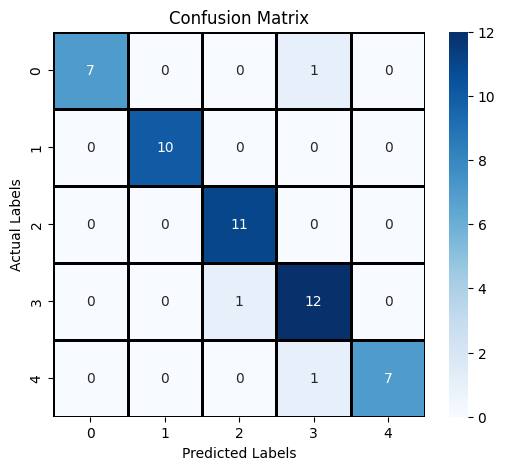

In [ ]:
conf_matrix_BERT_2 = confusion_matrix(y_true_BERT_2, y_pred_BERT_2)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_BERT_2, annot=True, fmt="d", cmap="Blues", linewidths=1, linecolor="black")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Running roberta-base
tokenized_dataset_roberta, tokenizer_roberta = preprocess_dataset('roberta-base', corrected_dset)

model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

roberta_trainer = hyperparameter_tuning(model, tokenizer_roberta, tokenized_dataset_roberta)

roberta_trainer.train()



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.624500,1.432471,0.360000,0.197089,0.400000,0.245024
2,1.236100,0.950661,0.620000,0.597647,0.627972,0.532143
3,0.768600,0.608403,0.820000,0.898810,0.802273,0.816830
4,0.424000,0.400563,0.920000,0.925714,0.906818,0.910053
5,0.196900,0.502409,0.840000,0.901429,0.806818,0.817143
6,0.053200,0.591274,0.840000,0.886842,0.806818,0.812067
7,0.015400,0.506715,0.880000,0.891818,0.866434,0.874675
8,0.010500,0.509621,0.900000,0.908802,0.891434,0.895730


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=152, training_loss=0.5411387018271183, metrics={'train_runtime': 227.4477, 'train_samples_per_second': 5.276, 'train_steps_per_second': 0.668, 'total_flos': 315741770956800.0, 'train_loss': 0.5411387018271183, 'epoch': 8.0})

In [ ]:
# Computing metrics

y_pred_all_roberta = roberta_trainer.predict(tokenized_dataset_roberta["validation"])
y_pred_roberta = np.argmax(y_pred_all_roberta[0], axis=1)
y_true_roberta = tokenized_dataset_roberta['validation']['label']
# f1_roberta = f1_score(y_true_roberta, y_pred_roberta, average='macro')


# Compute precision, recall, and F1-score
report_dict_roberta = classification_report(y_true_roberta, y_pred_roberta, digits=4, output_dict=True)

report_df_roberta = pd.DataFrame(report_dict_roberta).transpose()
report_df_roberta

,precision,recall,f1-score,support
0,0.700000,0.875000,0.777778,8.00
1,1.000000,1.000000,1.000000,10.00
2,1.000000,0.909091,0.952381,11.00
3,0.928571,1.000000,0.962963,13.00
4,1.000000,0.750000,0.857143,8.00
accuracy,0.920000,0.920000,0.920000,0.92
macro avg,0.925714,0.906818,0.910053,50.00
weighted avg,0.933429,0.920000,0.921481,50.00


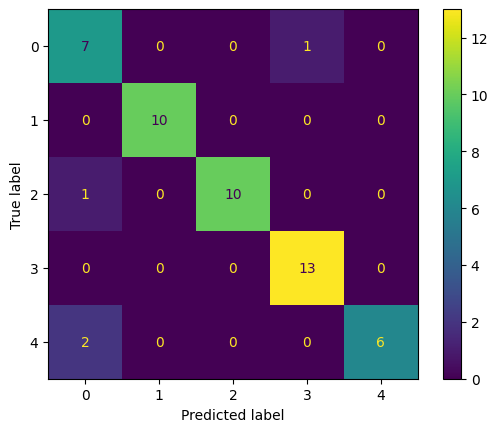

In [ ]:
# Plot confusion matrix
cm_roberta = confusion_matrix(y_true_roberta, y_pred_roberta)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_roberta)

disp.plot()

plt.show()

In [ ]:
# Running distilbert-base-uncased
tokenized_dataset_distilbert, tokenizer_distilbert = preprocess_dataset('distilbert-base-uncased', corrected_dset)

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

distilbert_trainer = hyperparameter_tuning(model, tokenizer_distilbert, tokenized_dataset_distilbert)

distilbert_trainer.train()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.477200,1.224218,0.620000,0.767018,0.620804,0.589501
2,0.936500,0.757120,0.800000,0.829524,0.785664,0.788728
3,0.446500,0.429635,0.920000,0.938462,0.919231,0.923993
4,0.167500,0.328490,0.920000,0.943333,0.909615,0.920828
5,0.060700,0.256661,0.940000,0.942949,0.934615,0.937586
6,0.036000,0.227749,0.940000,0.952564,0.944231,0.946000
7,0.025400,0.222437,0.960000,0.967949,0.959615,0.962586
8,0.022800,0.220338,0.960000,0.967949,0.959615,0.962586


TrainOutput(global_step=152, training_loss=0.3965798661504921, metrics={'train_runtime': 120.8888, 'train_samples_per_second': 9.926, 'train_steps_per_second': 1.257, 'total_flos': 158969382912000.0, 'train_loss': 0.3965798661504921, 'epoch': 8.0})

In [ ]:
# Compute metrics
y_pred_all_distilbert = distilbert_trainer.predict(tokenized_dataset_distilbert["validation"])
y_pred_distilbert = np.argmax(y_pred_all_distilbert[0], axis=1)
y_true_distilbert = tokenized_dataset_distilbert['validation']['label']
# f1_distilbert = f1_score(y_true_distilbert, y_pred_distilbert, average='macro')


# Compute precision, recall, and F1-score
report_dict_distilbert = classification_report(y_true_distilbert, y_pred_distilbert, digits=4, output_dict=True)

report_df_distilbert = pd.DataFrame(report_dict_distilbert).transpose()
report_df_distilbert

,precision,recall,f1-score,support
0,1.000000,0.875000,0.933333,8.00
1,1.000000,1.000000,1.000000,10.00
2,0.916667,1.000000,0.956522,11.00
3,0.923077,0.923077,0.923077,13.00
4,1.000000,1.000000,1.000000,8.00
accuracy,0.960000,0.960000,0.960000,0.96
macro avg,0.967949,0.959615,0.962586,50.00
weighted avg,0.961667,0.960000,0.959768,50.00


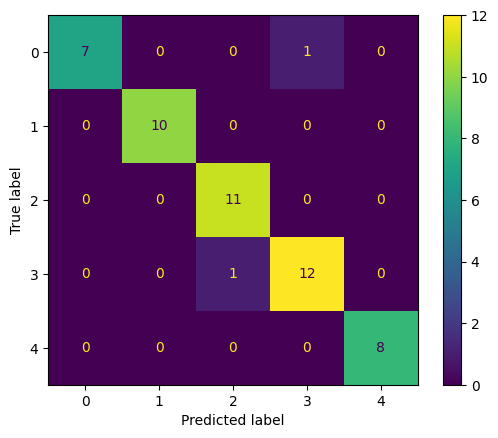

In [ ]:
# Confusion Matrix
cm_distilbert = confusion_matrix(y_true_distilbert, y_pred_distilbert)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_distilbert)
disp.plot()
plt.show()

In [ ]:
# Running microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract

tokenized_dataset_BiomedBERT, tokenizer_BiomedBERT = preprocess_dataset('microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract', corrected_dset)

model = AutoModelForSequenceClassification.from_pretrained('microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract', num_labels=5)
BiomedBERT_trainer = hyperparameter_tuning(model, tokenizer_BiomedBERT, tokenized_dataset_BiomedBERT)
BiomedBERT_trainer.train()


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.491400,1.290194,0.500000,0.478022,0.546154,0.431710
2,0.900800,0.758285,0.780000,0.792757,0.787937,0.776792
3,0.406300,0.579440,0.820000,0.811328,0.807867,0.807760
4,0.161200,0.623062,0.780000,0.753247,0.748252,0.739182
5,0.057000,0.678441,0.840000,0.830037,0.816434,0.818730
6,0.017100,0.675571,0.860000,0.860275,0.841434,0.842521
7,0.009700,0.712105,0.860000,0.854017,0.841434,0.839065
8,0.007700,0.716519,0.840000,0.821795,0.816434,0.815568


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=152, training_loss=0.3813949870435815, metrics={'train_runtime': 228.8997, 'train_samples_per_second': 5.242, 'train_steps_per_second': 0.664, 'total_flos': 315741770956800.0, 'train_loss': 0.3813949870435815, 'epoch': 8.0})

In [ ]:
# Compute metrics
y_pred_all_BiomedBERT = BiomedBERT_trainer.predict(tokenized_dataset_BiomedBERT["validation"])
y_pred_BiomedBERT = np.argmax(y_pred_all_BiomedBERT[0], axis=1)
y_true_BiomedBERT = tokenized_dataset_BiomedBERT['validation']['label']
# f1_BiomedBERT = f1_score(y_true_BiomedBERT, y_pred_BiomedBERT, average='macro')


# Compute precision, recall, and F1-score
report_dict_BiomedBERT = classification_report(y_true_BiomedBERT, y_pred_BiomedBERT, digits=4, output_dict=True)

report_df_BiomedBERT = pd.DataFrame(report_dict_BiomedBERT).transpose()
report_df_BiomedBERT

,precision,recall,f1-score,support
0,0.875000,0.875000,0.875000,8.00
1,1.000000,1.000000,1.000000,10.00
2,0.769231,0.909091,0.833333,11.00
3,0.857143,0.923077,0.888889,13.00
4,0.800000,0.500000,0.615385,8.00
accuracy,0.860000,0.860000,0.860000,0.86
macro avg,0.860275,0.841434,0.842521,50.00
weighted avg,0.860088,0.860000,0.852906,50.00


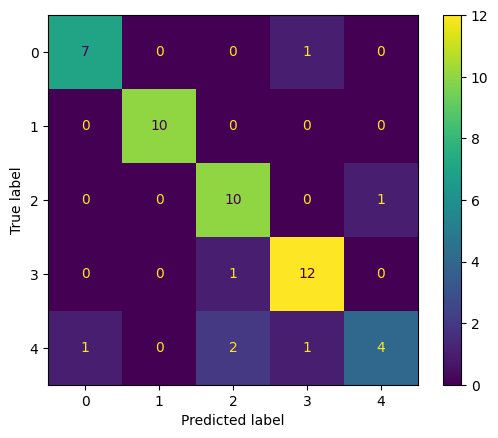

In [ ]:
# Confusion matrix
cm_BiomedBERT = confusion_matrix(y_true_BiomedBERT, y_pred_BiomedBERT)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_BiomedBERT)
disp.plot()
plt.show()

## Question 7

In [ ]:
# Final evaluation of the models using their F1-score (macro average)
f1_models = {
    'BERT_2'    : report_df_BERT_2.loc['macro avg','f1-score'],    # F1-score for the BERT model
    'distilbert' : report_df_distilbert.loc['macro avg','f1-score'], # F1-score for the DistilBERT model
    'roberta'    : report_df_roberta.loc['macro avg','f1-score'],    # F1-score for the RoBERTa model
    'BiomedBERT' : report_df_BiomedBERT.loc['macro avg','f1-score'], # F1-score for the BiomedBERT model
}

# Use pprint to neatly print the dictionary of F1-scores
import pprint as pp
pp.pprint(f1_models)

# Predict the labels for the BiomedBERT model using the validation dataset
y_pred_all_BiomedBERT = BiomedBERT_trainer.predict(tokenized_dataset_BiomedBERT["validation"])

# Get the predicted class labels by selecting the index with the highest probability
y_pred_BiomedBERT = np.argmax(y_pred_all_BiomedBERT[0], axis=1)

# Get the true class labels from the validation set for BiomedBERT
y_true_BiomedBERT = tokenized_dataset_BiomedBERT['validation']['label']

# Optionally, calculate the F1 score (commented out)
# f1_BiomedBERT = f1_score(y_true_BiomedBERT, y_pred_BiomedBERT, average='macro')

# Compute precision, recall, and F1-score for the BiomedBERT model
report_dict_BiomedBERT = classification_report(y_true_BiomedBERT, y_pred_BiomedBERT, digits=4, output_dict=True)

# Convert the classification report dictionary into a DataFrame for BiomedBERT
report_df_BiomedBERT = pd.DataFrame(report_dict_BiomedBERT).transpose()

# Predict the labels for the best model (DistilBERT) using the test dataset
y_pred_all_bestmodel = distilbert_trainer.predict(tokenized_dataset_distilbert["test"])

# Get the predicted class labels by selecting the index with the highest probability
y_pred_bestmodel = np.argmax(y_pred_all_bestmodel[0], axis=1)

# Get the true class labels from the test set for the best model
y_true_bestmodel = tokenized_dataset_distilbert['test']['label']

# Compute precision, recall, and F1-score for the best model (DistilBERT)
report_dict_bestmodel = classification_report(y_true_bestmodel, y_pred_bestmodel, digits=4, output_dict=True)

# Convert the classification report dictionary into a DataFrame for the best model
report_df_bestmodel = pd.DataFrame(report_dict_bestmodel).transpose()

# Display the classification report DataFrame for the best model
report_df_bestmodel

{'BERT_2': np.float64(0.942415458937198),
 'BiomedBERT': np.float64(0.8425213675213676),
 'distilbert': np.float64(0.9625863991081383),
 'roberta': np.float64(0.91005291005291)}


,precision,recall,f1-score,support
0,1.000000,0.846154,0.916667,13.0
1,0.875000,1.000000,0.933333,7.0
2,0.846154,1.000000,0.916667,11.0
3,0.857143,1.000000,0.923077,6.0
4,0.909091,0.769231,0.833333,13.0
accuracy,0.900000,0.900000,0.900000,0.9
macro avg,0.897478,0.923077,0.904615,50.0
weighted avg,0.907875,0.900000,0.898103,50.0
